In [24]:
import pandas as pd
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [25]:
df = pd.read_csv("data/data_ilr_transformed/d_study5_long.csv")

# Define the ilr columns and control columns
ilr_columns = ['ilr1', 'ilr2', 'ilr3']
control_columns = ['excluded', 'injustice', 'personal', 'violence']

df.isna().sum()

time           0
ID             0
ilr1           0
ilr2           0
ilr3           0
excluded       0
injustice      0
personal       0
violence       0
Vignette       0
gender        64
age            0
condition      0
Experiment     0
dtype: int64

In [26]:
df = df[df['gender'].notna()]

## Feature Engineering

In [27]:
# Creating -1 and -2 lag features for each ilr variable
for col in ilr_columns:
    df[f'{col}_lag1'] = df.groupby('ID')[col].shift(1)
    df[f'{col}_lag2'] = df.groupby('ID')[col].shift(2)

# Calculate mean and standard deviation per participant (ID) for each ilr column
for col in ilr_columns:
    # Mean per participant
    df[f'{col}_mean'] = df.groupby('ID')[col].transform('mean')
    
    # Standard deviation per participant
    df[f'{col}_std'] = df.groupby('ID')[col].transform('std')
    
    # Minimum and maximum values per participant
    df[f'{col}_min'] = df.groupby('ID')[col].transform('min')
    df[f'{col}_max'] = df.groupby('ID')[col].transform('max')


# Additional time-based feature: time point relative to the total duration for each participant
# This provides a scaled measure of progression within the time series
df['relative_time'] = df.groupby('ID')['time'].transform(lambda x: x / x.max())







# Optional cumulative feature: cumulative sum of the 'ilr' values within each participant's time series
# This can capture a trend or overall trajectory for each ilr over time
for col in ilr_columns:
    df[f'{col}_cumsum'] = df.groupby('ID')[col].cumsum()


## Response Variability Over Time:
for col in ilr_columns:
    df[f'{col}_delta'] = df.groupby('ID')[col].diff().fillna(0)  # Absolute change from previous time point


## Interaction Terms: Control Variables with Time
for col in control_columns:
    df[f'{col}_time_interaction'] = df[col] * df['time']


# Calculate the trend/slope for each ilr column
from sklearn.linear_model import LinearRegression
for col in ilr_columns:
    df[f'{col}_trend'] = df.groupby('ID').apply(lambda x: 
        LinearRegression().fit(x[['time']], x[col]).coef_[0] if len(x) > 1 else np.nan).reset_index(level=0, drop=True)


# Moving Average or Exponential Moving Average (EMA)
window_size = 2  # Define your preferred window size
for col in ilr_columns:
    df[f'{col}_moving_avg'] = df.groupby('ID')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    df[f'{col}_ema'] = df.groupby('ID')[col].transform(lambda x: x.ewm(span=window_size, adjust=False).mean())



/var/folders/gj/fcmn9wp14r38t18tn8lsb3qw0000gn/T/ipykernel_8626/3567501839.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df[f'{col}_trend'] = df.groupby('ID').apply(lambda x:
/var/folders/gj/fcmn9wp14r38t18tn8lsb3qw0000gn/T/ipykernel_8626/3567501839.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df[f'{col}_trend'] = df.groupby('ID').apply(lambda x:
/var/folders/gj/fcmn9wp14r38t18tn8lsb3qw0000gn

In [28]:



# Residualize each ilr variable
from statsmodels.regression.mixed_linear_model import MixedLM

for col in ilr_columns:
    # Fit the mixed-effects model
    model = MixedLM.from_formula(f"{col} ~ relative_time", groups="Experiment", data=df)
    result = model.fit()
    
    # Add residuals to the DataFrame
    df[f'{col}_residual'] = df[col] - result.fittedvalues

ilr_resid_columns = ['ilr1_residual', 'ilr2_residual', 'ilr3_residual']


ilr_moving_avg_cols = ['ilr1_moving_avg', 'ilr2_moving_avg', 'ilr3_moving_avg']


# Number of Fourier components to retain
fourier_components = 1

# Compute Fourier transform for each 'ilr' variable per participant
for col in ilr_moving_avg_cols:
    def compute_fourier(x):
        fft_vals = np.fft.fft(x)
        # Retain only the first N components (real and imaginary parts)
        return np.hstack([fft_vals.real[:fourier_components], fft_vals.imag[:fourier_components]])

    # Apply Fourier transformation and store as separate columns
    fourier_df = (
        df.groupby('ID')[col]
        .apply(lambda x: compute_fourier(x.values))
        .apply(pd.Series)
        .rename(columns=lambda i: f'{col}_fourier_{i+1}')
    )

    # Add Fourier features back to the dataframe
    df = df.join(fourier_df, on='ID')


In [34]:
# Define the feature columns to include in time series
feature_columns = [
    'condition', 
    'gender', 
    'age',
    #'ilr1', 'ilr2', 'ilr3', 
    'excluded', 'injustice', 'personal', 'violence',
    #'ilr1_lag1', 'ilr2_lag1', 'ilr3_lag1', 'ilr1_lag2', 'ilr2_lag2', 'ilr3_lag2',
    'ilr1_mean', 'ilr2_mean', 'ilr3_mean', 'ilr1_std', 'ilr2_std', 'ilr3_std',
    'ilr1_min', 'ilr2_min', 'ilr3_min', 'ilr1_max', 'ilr2_max', 'ilr3_max',
    'relative_time', 
    ######'ilr1_cumsum', 'ilr2_cumsum', 'ilr3_cumsum', 
    ######'ilr1_delta', 'ilr2_delta', 'ilr3_delta',  ### definitely nono
    #'excluded_time_interaction', 'injustice_time_interaction', 'personal_time_interaction', 'violence_time_interaction',
    #'ilr1_deviation_from_group', 'ilr2_deviation_from_group', 'ilr3_deviation_from_group',
    #'ilr1_trend', 'ilr2_trend', 'ilr3_trend', 
    # 'ilr1_moving_avg', 'ilr2_moving_avg', 'ilr3_moving_avg', 
    ######'ilr1_ema', 'ilr2_ema', 'ilr3_ema',
    # 'ilr1_residual', 'ilr2_residual', 'ilr3_residual',
    # 'ilr1_fourier_1', 'ilr2_fourier_1', 'ilr3_fourier_1',
    #'ilr1_fourier_2', 'ilr2_fourier_2', 'ilr3_fourier_2',
    # 'ilr1_moving_avg_fourier_1', 'ilr2_moving_avg_fourier_2', 'ilr3_moving_avg_fourier_1'
]

In [35]:
time_series_data = []
grouped = df.groupby("ID")

# Preprocess the time series data for each participant
for participant, group in grouped:
    group_sorted = group.sort_values("time")
    time_series = group_sorted[feature_columns].values
    
    # Pad or truncate each participant's time series to the same length
    max_length = 16  # Adjust as necessary
    if len(time_series) < max_length:
        time_series = np.pad(time_series, ((0, max_length - len(time_series)), (0, 0)), 'constant', constant_values=np.nan)
    else:
        time_series = time_series[:max_length]
    
    time_series_data.append(time_series)

# Convert to numpy array for clustering
time_series_data = np.array(time_series_data)

Modelling for cluster = 1 is done.
Modelling for cluster = 2 is done.
Modelling for cluster = 3 is done.
Modelling for cluster = 4 is done.
Modelling for cluster = 5 is done.
Modelling for cluster = 6 is done.
Modelling for cluster = 7 is done.


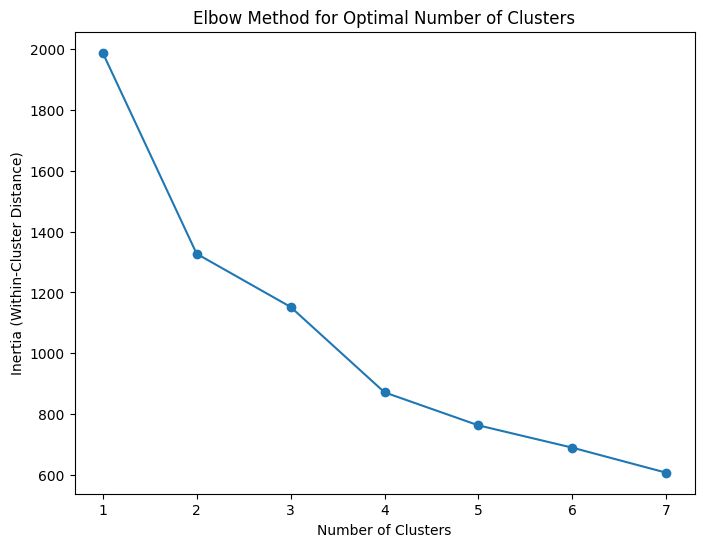

In [15]:
# Elbow method
# Define the range for possible number of clusters
inertia = []
cluster_range = range(1, 8)  # Test 1 to 10 clusters; adjust as needed

for n_clusters in cluster_range:
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
    print(f"Modelling for cluster = {n_clusters} is done.")
    model.fit(time_series_data)
    inertia.append(model.inertia_)  # Append the inertia for each model

# Step 4: Plot the inertia to find the "elbow"
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Within-Cluster Distance)")
plt.show()

## ...

In [36]:
# Set number of clusters (use elbow method result or other criteria)
n_clusters = 4

# Fit the clustering model
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
labels = model.fit_predict(time_series_data)

# Add labels to the original DataFrame for analysis
df["cluster"] = df["ID"].map(dict(zip(grouped.groups.keys(), labels)))

In [37]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Flatten each time series (samples x time points x features) to (samples x (time points * features))
time_series_data_flattened = time_series_data.reshape(time_series_data.shape[0], -1)

# Option 1: Remove any columns that contain NaNs (these correspond to padded sections)
time_series_data_flattened_no_nans = time_series_data_flattened[:, ~np.isnan(time_series_data_flattened).any(axis=0)]

# Option 2: Fill NaNs with column means if you prefer not to discard columns
# col_means = np.nanmean(time_series_data_flattened, axis=0)
# indices = np.where(np.isnan(time_series_data_flattened))
# time_series_data_flattened[indices] = np.take(col_means, indices[1])

# Calculate silhouette score using the adjusted data
try:
    baseline_silhouette = silhouette_score(time_series_data_flattened_no_nans, labels)
    print(f"Silhouette Score (with NaN columns removed): {baseline_silhouette}")
except ValueError as e:
    print(f"Error calculating silhouette score: {e}")

# Calculate Davies-Bouldin score using the adjusted data
try:
    baseline_davies_bouldin = davies_bouldin_score(time_series_data_flattened_no_nans, labels)
    print(f"Davies-Bouldin Score (with NaN columns removed): {baseline_davies_bouldin}")
except ValueError as e:
    print(f"Error calculating Davies-Bouldin score: {e}")


Silhouette Score (with NaN columns removed): 0.30737615002968544
Davies-Bouldin Score (with NaN columns removed): 1.0297302304588718


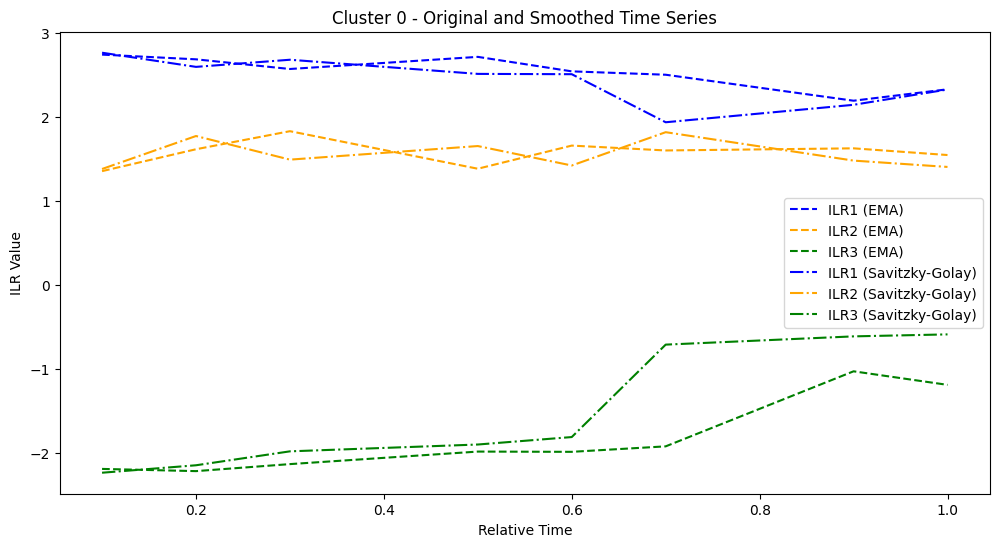

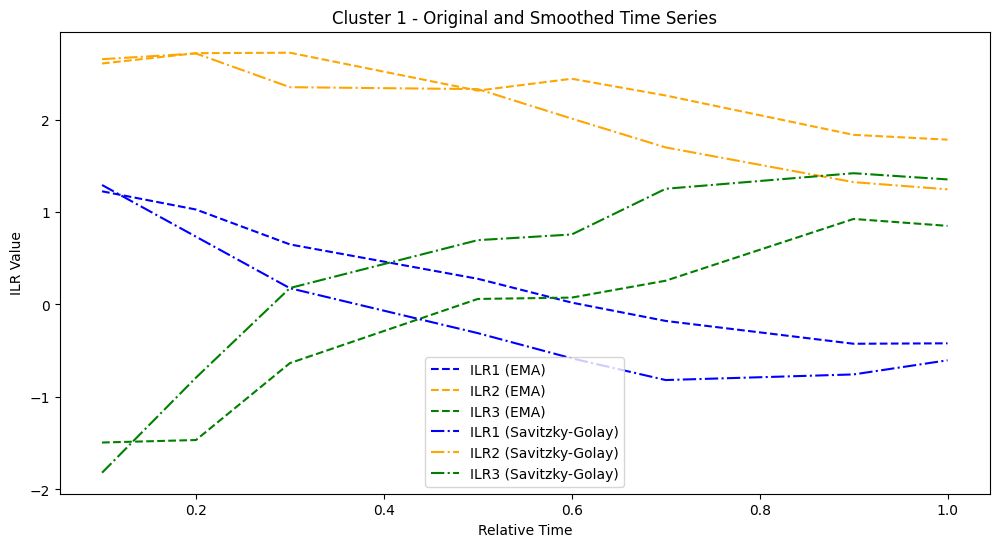

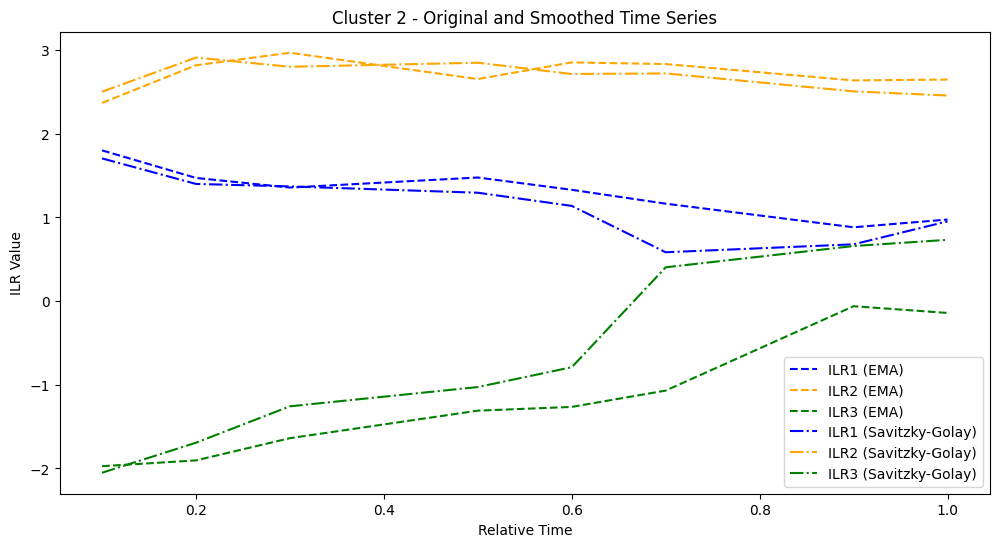

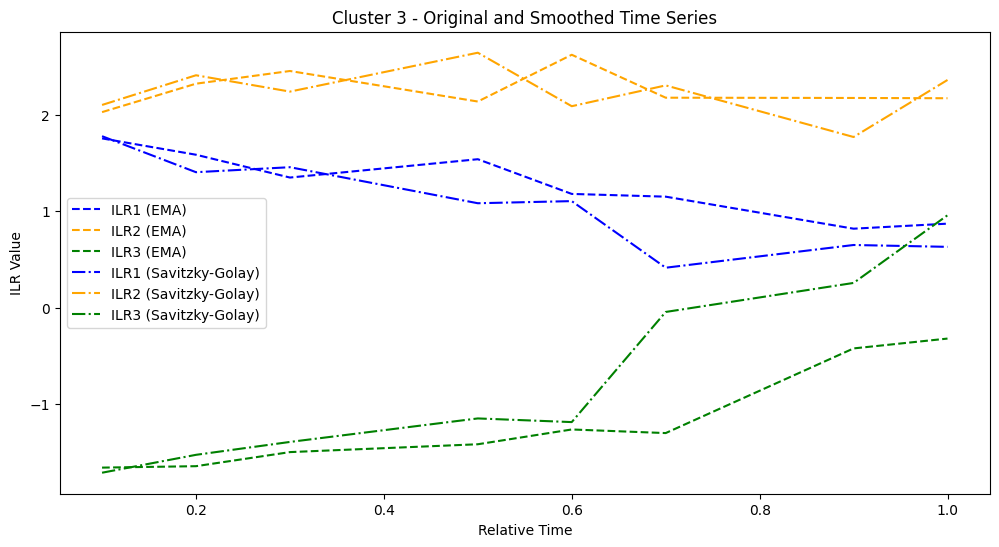

In [20]:
# Creating a relative time variable for each participant
df['relative_time'] = df.groupby('ID')['time'].transform(lambda x: x / x.max())

# Define the number of clusters (adjust to the actual number of clusters)
n_clusters = 4

# Smoothing parameters
alpha = 0.2  # Smoothing factor for EMA
savgol_window = 3  # Window length for Savitzky-Golay filter
savgol_polyorder = 1  # Polynomial order for Savitzky-Golay filter

for cluster in range(n_clusters):
    cluster_data = df[df['cluster'] == cluster]
    
    # Group by relative time and calculate the mean of ilr variables
    mean_relative = cluster_data.groupby('relative_time')[['ilr1', 'ilr2', 'ilr3']].mean()
    
    # Apply Exponential Moving Average (EMA) smoothing
    mean_ilr_smooth_ema = mean_relative.apply(lambda x: x.ewm(alpha=alpha).mean())
    
    # Apply Savitzky-Golay Filter smoothing
    mean_ilr_smooth_savgol = pd.DataFrame({
        "ilr1": savgol_filter(mean_relative["ilr1"], window_length=savgol_window, polyorder=savgol_polyorder),
        "ilr2": savgol_filter(mean_relative["ilr2"], window_length=savgol_window, polyorder=savgol_polyorder),
        "ilr3": savgol_filter(mean_relative["ilr3"], window_length=savgol_window, polyorder=savgol_polyorder)
    }, index=mean_relative.index)

    # Plot the original and smoothed series for each ILR variable in the cluster
    plt.figure(figsize=(12, 6))
    
    # Plot EMA smoothed series3
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["ilr1"], label="ILR1 (EMA)", linestyle="--", color="blue")
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["ilr2"], label="ILR2 (EMA)", linestyle="--", color="orange")
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["ilr3"], label="ILR3 (EMA)", linestyle="--", color="green")

    # Plot Savitzky-Golay smoothed series
    plt.plot(mean_relative.index, mean_ilr_smooth_savgol["ilr1"], label="ILR1 (Savitzky-Golay)", linestyle="-.", color="blue")
    plt.plot(mean_relative.index, mean_ilr_smooth_savgol["ilr2"], label="ILR2 (Savitzky-Golay)", linestyle="-.", color="orange")
    plt.plot(mean_relative.index, mean_ilr_smooth_savgol["ilr3"], label="ILR3 (Savitzky-Golay)", linestyle="-.", color="green")
    
    # Formatting the plot
    plt.xlabel("Relative Time")
    plt.ylabel("ILR Value")
    plt.title(f"Cluster {cluster} - Original and Smoothed Time Series")
    plt.legend()
    plt.show()